In [2]:
!pip install -q transformers datasets accelerate sentencepiece pandas bitsandbytes peft evaluate einops scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.1 MB/s eta 0:00:00


In [1]:
pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00


In [3]:
from transformers import DataCollatorForLanguageModeling


In [4]:
pip install -U bitsandbytes

In [5]:
!pip install -U bitsandbytes
!pip install -U accelerate
!pip install -U transformers
!pip install -U peft
!pip install -U datasets
!pip install -U rouge-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=321a53ca7de0719a04ffe5d8f184da0e1aa96e20ba58d39cdc9aadd1b7bb37a5
  Stored in directory: /root/.cache/pip/whee

In [10]:
# [Imports]
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import Dataset
import pandas as pd
import ast
import evaluate
import os

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == "cuda" else None
print(f"Using device: {device}")

# Data loading + formatting
def prepare_data(file_path, sample_size=1500):
    df = pd.read_csv(file_path, nrows=sample_size)
    df["dialog"] = df["dialog"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    def format_convo(dialog):
        conv = "<|im_start|>system\nYou are a helpful assistant<|im_end|>\n"
        for i, text in enumerate(dialog):
            role = "user" if i % 2 == 0 else "assistant"
            text = text[:150] + "..." if len(text) > 150 else text
            conv += f"<|im_start|>{role}\n{text.strip()}<|im_end|>\n"
        return conv

    texts = [format_convo(d) for d in df["dialog"]]
    return Dataset.from_dict({"text": texts})

train_dataset = prepare_data("train.csv", sample_size=500)

# Load base model/tokenizer
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16,
    load_in_4bit=True

# Prepare model for PEFT + LoRA
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules = ["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Tokenization
def tokenize(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        padding="max_length"
    )

tokenized_train = train_dataset.map(tokenize, batched=True, remove_columns=["text"])
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask"])

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


# Training Args
training_args = TrainingArguments(
    output_dir="./qwen2.5-lora-finetuned",
    num_train_epochs=10,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    logging_steps=10,
    save_steps=200,
    learning_rate=2e-4,
    fp16=True,
    report_to="none",
    save_total_limit=1,
    gradient_checkpointing=True,
)

# Trainer Init
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=data_collator
)

# Train
print("Training started...")
trainer.train()



Using device: cuda


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training started...


Step,Training Loss
10,4.706500
20,4.035200
30,3.548300
40,3.198600
50,3.120600
60,2.911900
70,2.915900
80,2.841500
90,2.736200
100,2.659900


TrainOutput(global_step=320, training_loss=2.696466511487961, metrics={'train_runtime': 794.6604, 'train_samples_per_second': 6.292, 'train_steps_per_second': 0.403, 'total_flos': 2752809861120000.0, 'train_loss': 2.696466511487961, 'epoch': 10.0})

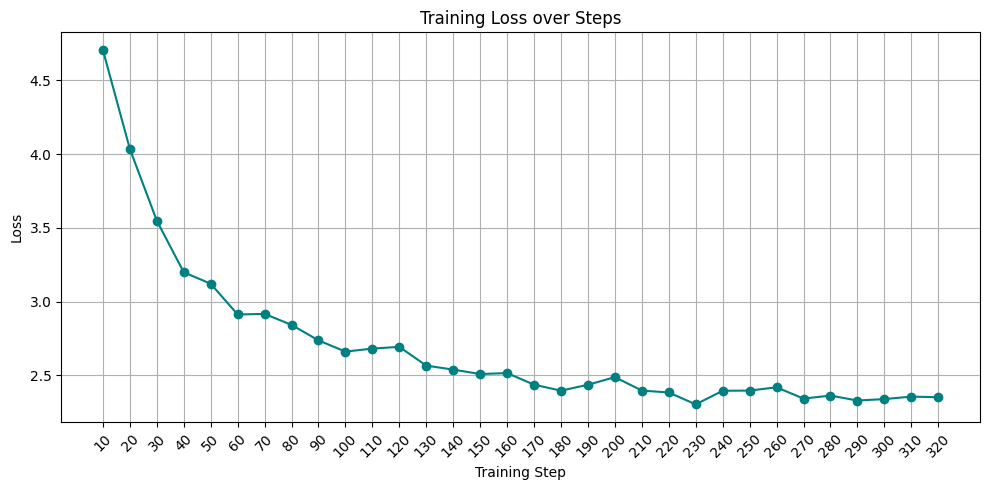

In [16]:
import matplotlib.pyplot as plt

# Step numbers (every 10 steps)
steps = list(range(10, 330, 10))

# training loss values
losses = [
    4.7065, 4.0352, 3.5483, 3.1986, 3.1206, 2.9119, 2.9159, 2.8415, 2.7362, 2.6599,
    2.6806, 2.6923, 2.5650, 2.5379, 2.5079, 2.5145, 2.4355, 2.3950, 2.4350, 2.4868,
    2.3956, 2.3828, 2.3020, 2.3942, 2.3956, 2.4178, 2.3412, 2.3615, 2.3281, 2.3378,
    2.3546, 2.3505
]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', linestyle='-', color='teal')
plt.title("Training Loss over Steps")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.xticks(steps, rotation=45)
plt.tight_layout()
plt.show()


In [12]:
import evaluate
rouge = evaluate.load("rouge")

predictions = ["The cat sat on the mat."]
references = ["A cat is sitting on the mat."]

rouge.add_batch(predictions=predictions, references=references)
print(rouge.compute())


{'rouge1': np.float64(0.6153846153846153), 'rouge2': np.float64(0.3636363636363636), 'rougeL': np.float64(0.6153846153846153), 'rougeLsum': np.float64(0.6153846153846153)}


In [13]:
import numpy as np
from tqdm import tqdm
import torch

def compute_perplexity(model, dataset, max_samples=100):
    model.eval()
    # Ensure model is on the correct device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    losses = []

    # Evaluate on a subset of the *tokenized* dataset
    subset = dataset.select(range(min(len(dataset), max_samples)))

    for i in tqdm(range(len(subset))):
        # Access tokenized data directly
        inputs = {k: v.unsqueeze(0).to(model.device) for k, v in subset[i].items()}

        with torch.no_grad():
            # Use the tokenized input_ids and attention_mask
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss.item()
            losses.append(loss)

    perplexity = np.exp(np.mean(losses))
    return perplexity

# Call it with the tokenized dataset
print("Perplexity:", compute_perplexity(model, tokenized_train))

100%|██████████| 100/100 [00:11<00:00,  8.41it/s]

Perplexity: 3496066.53683379


In [15]:

peft_path = "./qwen2.5-lora-adapter"
model.save_pretrained(peft_path)
tokenizer.save_pretrained(peft_path)
print(f"\n LoRA adapter saved to {peft_path}")

# Save full model
full_model_path = "./qwen2.5-lora-full"
model.base_model.save_pretrained(full_model_path)
tokenizer.save_pretrained(full_model_path)
print(f" Full model with adapter saved to {full_model_path}")

# Human Evaluation Prompt
print("\n Human Evaluation Prompt:")
example = "<|im_start|>user\nHow do I improve my Python skills?<|im_end|>\n<|im_start|>assistant\n"
input_ids = tokenizer(example, return_tensors="pt").to(model.device)

output = model.generate(
    input_ids.input_ids,
    max_new_tokens=100,
    temperature=0.7,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id
)

generated = tokenizer.decode(output[0], skip_special_tokens=False)
response = generated.split("<|im_start|>assistant\n")[-1].split("<|im_end|>")[0]
print("\n Assistant's Response:\n", response)
print("\n Human Eval → Rate on: Relevance, Coherence, Helpfulness (1–5 stars)")


✅ LoRA adapter saved to ./qwen2.5-lora-adapter


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Full model with adapter saved to ./qwen2.5-lora-full

📋 Human Evaluation Prompt:

💬 Assistant's Response:
 I'm not sure. I think you should do more reading on the website and study online for a while. You can't expect to learn everything on your own. You must... SupportedExceptions
What are you suggesting?ustauser
What is the appropriate website for improving your Python skills?localctx
Thank you for your help. You're welcome. This site is great, but I don't have a computer. I have no computer. Let's try to help you with your computer. 

🧠 Human Eval → Rate on: Relevance, Coherence, Helpfulness (1–5 stars)


In [17]:
from transformers import pipeline
import torch

# List of user prompts for evaluation
prompts = [
    "How do I improve my Python skills?",
    "What is the future of AI in healthcare?",
    "Explain the concept of attention mechanism in transformers.",
    "How can I get started with machine learning?",
    "What are the best practices for clean code?"
]

# Prepare inputs
formatted_prompts = [
    f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n" for prompt in prompts
]

# Generate responses
for i, prompt in enumerate(formatted_prompts):
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        input_ids.input_ids,
        max_new_tokens=150,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )

    generated = tokenizer.decode(output[0], skip_special_tokens=False)
    response = generated.split("<|im_start|>assistant\n")[-1].split("<|im_end|>")[0]

    # Print for human evaluation
    print(f"\n Prompt {i+1}: {prompts[i]}")
    print(f" Assistant Response:\n{response}")
    print(" Human Eval → Rate on: Relevance, Coherence, Helpfulness (1–5 stars)\n")



 Prompt 1: How do I improve my Python skills?
 Assistant Response:
You are always asking for advice. You're always asking for help. You never gave your advice to anyone. You never gave any advice to me. Your advice is always helpful. You are always making a mistake. You are always making a mistake. You never gave me any advice. You are always making a mistake. You are making a mistake all day. Tell me what you are doing wrong. Tell me where the...查看全文继续下页查看
计算机软件和电工技术
计算机软件和电工技术
计算机和电气工程
计算机和工程
计算机和电气工程
计算机和工程
计算机和电气工程
计算机和工程
计算机和电气工程
计算机和工程
计算机和工程
计算机和工程
计算机和工程
 Human Eval → Rate on: Relevance, Coherence, Helpfulness (1–5 stars)


 Prompt 2: What is the future of AI in healthcare?
 Assistant Response:
Yes, it has the potential to be an incredible help for healthcare.ileo
ileo
It’s true. It’s already happening in some countries. We’ve seen first hand the benefits of the new machines.ileo
ileo
I don’t agree with you. I don’t think it’s a good bet.ileo
ileo
The idea of using machines to

In [18]:
import shutil

# Zip the LoRA adapter
shutil.make_archive('qwen2.5-lora-adapter', 'zip', './qwen2.5-lora-adapter')

# Zip the full model
shutil.make_archive('qwen2.5-lora-full', 'zip', './qwen2.5-lora-full')


'/content/qwen2.5-lora-full.zip'

In [19]:
from google.colab import files

# Download zipped LoRA adapter
files.download('qwen2.5-lora-adapter.zip')

# Download zipped full model
files.download('qwen2.5-lora-full.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>